In [25]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
background-color: transparent !important;
}
/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
--jp-widgets-color: var(--vscode-editor-foreground);
--jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.signal import find_peaks, peak_widths

In [2]:
# sheets importieren
sheet_names = [
    "Na22",
    "Cs",
    "Co",
    "Schutz",
    "Nackt",
    "K2CO3",
    "Melke die Molke",
    "Uranoxid",
    "Thor",
    "Pilze nur Pilze",
]
sheets = [pd.read_excel("RAD.xlsx", sheet_name=name) for name in sheet_names]
sheets = (
    pd.concat(dict(zip(sheet_names, sheets)))
    .drop(columns=["n_A#2", "N_A#2", "n_A#3", "N_A#3"])
    .rename(columns={"n_A": "Channel", "N_A": "Events"})
    .reset_index()
    .set_index(["level_0", "Channel"])
    .drop(columns="level_1")
)
sheets

Events
level_0         Channel        
Na22            0             6
                1            14
                2             9
                3             7
                4             3
...                         ...
Pilze nur Pilze 1019          0
                1020          0
                1021          0
                1022          0
                1023        984

[10240 rows x 1 columns]

## Kalibrierkurven

In [3]:
def get_peaks(series, prominence=100):
    # peaks finden
    peaks = find_peaks(sheets.loc[series, "Events"], prominence=prominence)[0]
    # unsicherheiten bestimmen
    widths = peak_widths(sheets.loc[series, "Events"], peaks)[0]
    peaks = pd.DataFrame(
        {
            "Channel": peaks,
            "Events": sheets.loc[series, "Events"].iloc[peaks],
            "Width": widths,
        }
    )
    return peaks

def peak_plot(series, peaks):
    plt.plot(sheets.loc[series, "Events"])
    plt.plot(peaks["Channel"], peaks["Events"], "x")
    plt.grid(True)
    plt.xlabel("Channel")
    plt.ylabel("Events")

,Channel,Events,Width,Energy
Channel,,,,
186,187.1,900,4.5,511
446,447.5,164,3.7,1275


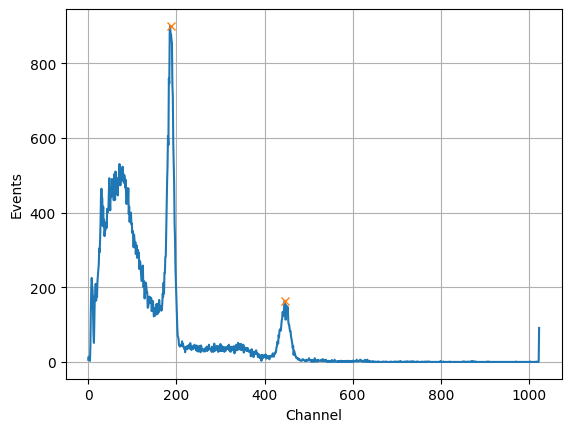

In [4]:
peaks = get_peaks("Na22")
na_peaks = peaks.drop(index=[8, 30])
na_peaks["Energy"] = [511, 1275, 1787]
na_peaks["Width"] = [23.4, 4.5, 3.7]
na_peaks["Channel"] = [62.2, 187.1, 447.5]
na_peaks = na_peaks.drop(index=[71])
na_peaks["Energy"] = [511, 1275]
peak_plot("Na22", na_peaks)
na_peaks

,Channel,Events,Width,Energy
Channel,,,,
413,417.1,30,0.0,1173
466,466.7,28,4.7,1333


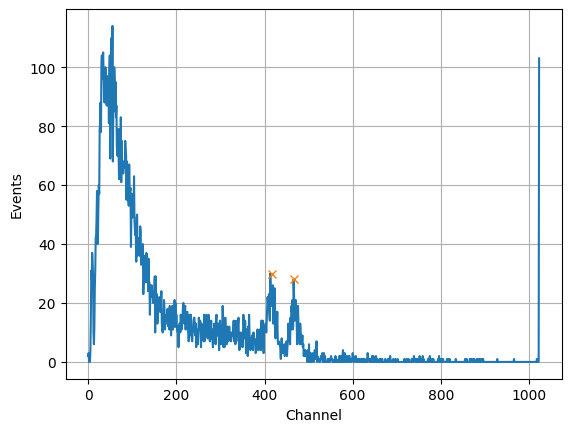

In [5]:
peaks = get_peaks("Co", prominence=25)
co_peaks = peaks.drop(index=[9, 34, 59])
co_peaks["Energy"] = [1173, 1333, 2506]
co_peaks["Channel"] = [38.2, 417.1, 466.7]
co_peaks["Width"] = [0, 0, 4.7]
co_peaks = co_peaks.drop(index=55)
co_peaks["Energy"] = [1173, 1333]
peak_plot("Co", co_peaks)
co_peaks

,Channel,Events,Width,Energy
Channel,,,,
242,241.5,4810,4.7,662


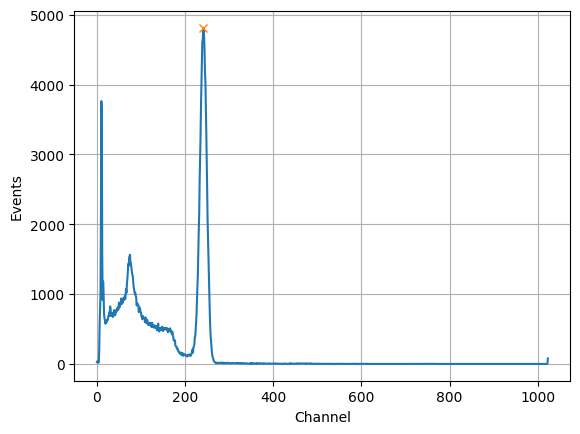

In [6]:
cs_peaks = get_peaks("Cs", prominence=100)
cs_peaks = cs_peaks.drop(index=[10, 14, 30, 75])
cs_peaks["Energy"] = [662]
cs_peaks["Width"] = [4.7]
cs_peaks["Channel"] = [241.5]
peak_plot("Cs", cs_peaks)
cs_peaks

In [7]:
peaks = pd.concat([na_peaks, co_peaks]).sort_index()
peaks

,Channel,Events,Width,Energy
Channel,,,,
186,187.1,900,4.5,511
413,417.1,30,0.0,1173
446,447.5,164,3.7,1275
466,466.7,28,4.7,1333


In [8]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear, peaks["Channel"], peaks["Energy"])
popt, pcov

(array([  2.92733499, -38.21636309]),
 array([[ 1.31849922e-03, -5.00502212e-01],
        [-5.00502212e-01,  2.06689156e+02]]))

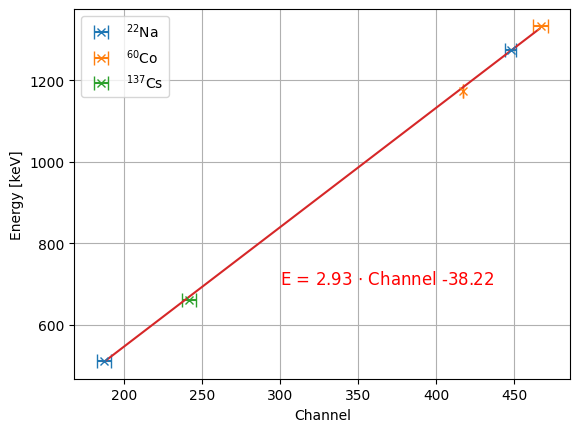

In [22]:
Channels = np.arange(peaks["Channel"].min(), peaks["Channel"].max(), 1)
Energy = linear(Channels, *popt)
plt.errorbar(na_peaks["Channel"], na_peaks["Energy"], xerr=na_peaks["Width"], fmt="x", capsize=5, label=r"$^{22}$Na")
plt.errorbar(co_peaks["Channel"], co_peaks["Energy"], xerr=co_peaks["Width"], fmt="x", capsize=5, label=r"$^{60}$Co")
plt.errorbar(cs_peaks["Channel"], cs_peaks["Energy"], xerr=cs_peaks["Width"], fmt="x", capsize=5, label=r"$^{137}$Cs")
plt.plot(Channels, Energy)
plt.grid(True)
plt.ylabel("Energy [keV]")
plt.xlabel("Channel")
plt.annotate(r"E = " + f"{popt[0]:.2f}" + r" $\cdot$ Channel " + f"{popt[1]:.2f}", (300, 700), fontsize=12, c="r")
plt.legend()

In [24]:
def e_channel(channel):
    return linear(channel, *popt)

## Hoehenstrahlung

In [28]:
df = pd.read_excel("RAD-Cosmic.xlsx")
df

,Kalibrierung Co-60,Unnamed: 1,Messung,Unnamed: 3
0,Dauer,400 s,Dauer,120 min
1,NaN,NaN,NaN,NaN
2,Kanal,Anzahl,Kanal,Anzahl
3,0,0,0,0
4,1,0,1,0
...,...,...,...,...
1022,1019,0,1019,5
1023,1020,0,1020,1
1024,1021,0,1021,1
1025,1022,1,1022,2


0       0
1       0
2       0
3       0
4       0
       ..
1019    0
1020    0
1021    0
1022    1
1023    2
Length: 1024, dtype: object

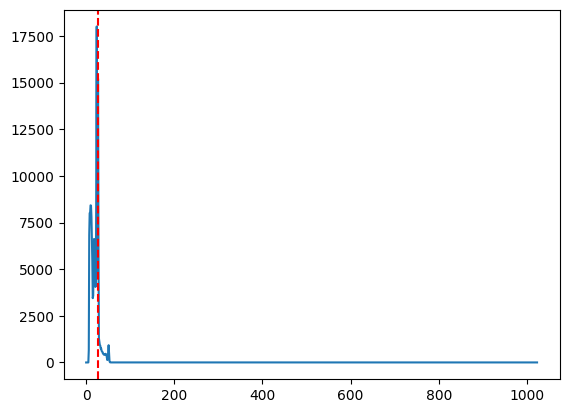

In [48]:
co_channel = df["Kalibrierung Co-60"].iloc[3:]
co_events = df["Unnamed: 1"].iloc[3:]
measurement_channel = df["Messung"].iloc[3:]
measurement_events = df["Unnamed: 3"].iloc[3:]

calibration = pd.Series(co_events.values, index=co_channel.values)
plt.plot(calibration.index, calibration, label="Kalibrierung")
plt.axvline(27, linestyle="--", c="r")
calibration

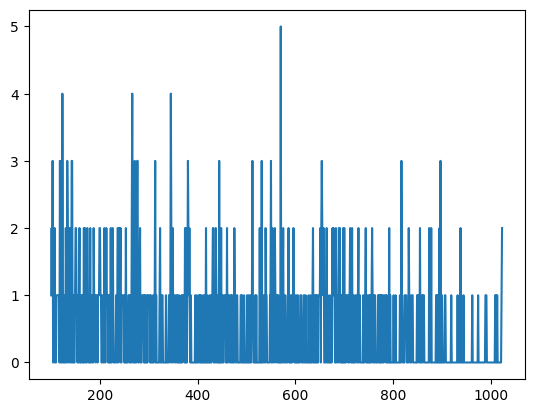

In [49]:
subset = calibration.iloc[100:]
plt.plot(subset.index, subset, label="Kalibrierung")

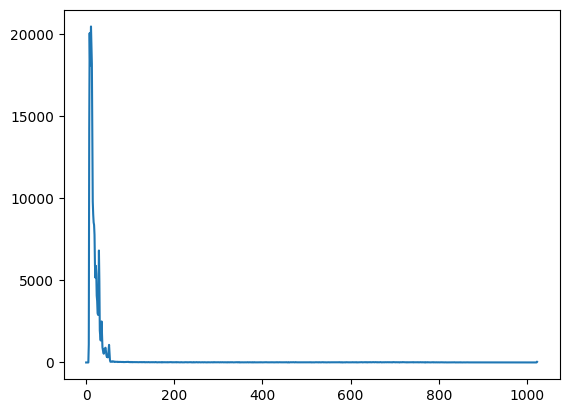

In [50]:
measurement = pd.Series(measurement_events.values, index=measurement_channel.values)
plt.plot(measurement.index, measurement, label="Messung")

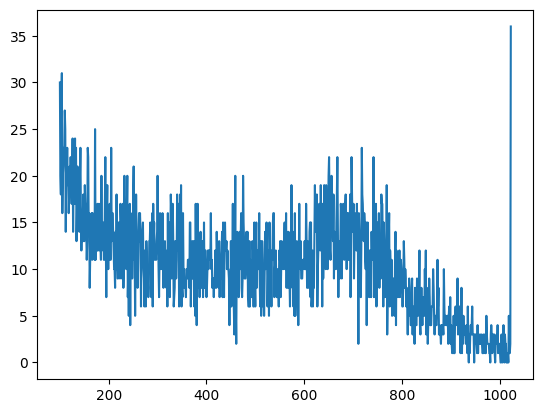

In [51]:
subset = measurement.iloc[100:]
plt.plot(subset.index, subset, label="Messung")